stop_early 在跑

In [66]:
import pandas as pd
pd.set_option('display.max_rows', None)  # 显示所有行
pd.set_option('display.max_columns', None)  # 显示所有列

In [67]:
import pandas as pd

measure_latency = 1244.4444444444443
# 读入 CSV 文件
df = pd.read_csv('evaluate_num_segments.csv')
# df = pd.read_csv('evaluate_seg.csv')

df = df.drop(columns=['pbid'])
df = df[df['ARG'] <= 100000]
# df = df[df['classcial'] <= 500]
# df = df[df['in_constraints_probs'] >= 99]

# 读取 quantumtime.csv 文件，计算 quantum 时间
df_quantum = pd.read_csv('quantumtime.csv')
# 聚合：对每个 pkid 和 method 计算 'latency_all' 的平均值
df_quantum = df_quantum.groupby(['pkid', 'method'], as_index=False).agg({
    'latency_all': 'mean',
})

df_quantum = df_quantum[(df_quantum['method'] == 'QtoSimplifyDiscardSolver') &  ((df_quantum['pkid'] % 4 == 2) | (df_quantum['pkid'] % 4 == 3))]
df_quantum['pkid'] = (df_quantum['pkid'] - 1) // 2
# df_quantum.head()        
# 将时间（单位：纳秒）转换为秒，并乘以 300*1024
df_quantum['quantum'] = (df_quantum['latency_all'] * 300 * 1024) / 1e9  # 转换成秒
# df_quantum.head(10)
# 通过 pkid 和 method 合并到 df 中，使用 suffixes 来避免列名冲突
df = pd.merge(df, df_quantum[['pkid', 'quantum']], on=['pkid'], how='left', suffixes=('', '_new'))

# 用合并后的 'quantum_new' 替换原有的 'quantum' 列
df['quantum'] = df['quantum_new']

# 删除合并时新增的 'quantum_new' 列
df.drop(columns=['quantum_new'], inplace=True)

df['pkid']=df['pkid'] % 2
df['quantum'] = df['quantum'] + measure_latency * (df['run_times'] - 300 * 1024) / 1e9

grouped_df = df.groupby(['pkid', 'num_segments', 'method'], as_index=False).agg({
    'iteration_count':'mean',
    'classcial':'max',
    'quantum':'mean',
    'run_times':'mean',
})

## 分组并把组作为索引
pivot_df = grouped_df.pivot(index =['pkid','num_segments'], columns='method', values=['quantum', 'classcial', 'run_times','iteration_count'])
# pivot_df = grouped_df.pivot(index =['pkid','variables','constraints'], columns='method', values=['best_solution_probs','in_constraints_probs',"ARG",'iteration_count'])

method_order = ['QtoSimplifyDiscardSegmentedCustomSolver']
# method_order = ['HeaSolver', 'PenaltySolver', 'ChocoSolver', 'QtoSolver ', 'QtoSimplifySolver', 'QtoSimplifyDiscardSolver', 'QtoSimplifyDiscardSegmentedCustomSolver']
# method_order = ['ChocoSolver', 'QtoSolver', 'QtoSimplifySolver', 'QtoSimplifyDiscardSolver']
# method_order = ['ChocoSolver']
# method_order = ['QtoSimplifyDiscardSegmentedCustomSolver']
pivot_df = pivot_df.reindex(columns=pd.MultiIndex.from_product([['classcial', "quantum",'run_times','iteration_count'], method_order]))

pivot_df

classcial  \
                  QtoSimplifyDiscardSegmentedCustomSolver   
pkid num_segments                                           
0    1                                         138.716119   
     2                                         273.580976   
     3                                         367.559911   
     4                                         377.497714   
     5                                         418.364604   
     6                                         443.288904   
     7                                         458.928551   
     8                                         496.723601   
     9                                         467.098217   
     10                                        671.293631   
1    1                                         169.451843   
     2                                         798.288377   
     3                                         967.130710   
     4                                        1225.115275   
     5                                        1342.304644   
     6                                        1315.902502   
     7                                        1413.820836   
     8                                        1366.705754   
     9                                        1690.010564   
     10                                       1718.451109   

                                                  quantum  \
                  QtoSimplifyDiscardSegmentedCustomSolver   
pkid num_segments                                           
0    1                                        1473.148097   
     2                                        1471.378734   
     3                                        1471.758802   
     4                                        1474.291500   
     5                                        1474.679061   
     6                                        1477.213542   
     7                                        1477.589241   
     8                                        1475.817314   
     9                                        1476.193266   
     10                                       1476.578210   
1    1                                        4701.308509   
     2                                        4701.690420   
     3                                        4702.070598   
     4                                        4702.454727   
     5                                        4702.838027   
     6                                        4703.218434   
     7                                        4703.605614   
     8                                        4703.984155   
     9                                        4704.369080   
     10                                       4704.735336   

                                                run_times  \
                  QtoSimplifyDiscardSegmentedCustomSolver   
pkid num_segments                                           
0    1                                       3.052136e+05   
     2                                       6.105566e+05   
     3                                       9.159680e+05   
     4                                       1.224019e+06   
     5                                       1.535452e+06   
     6                                       1.833345e+06   
     7                                       2.135246e+06   
     8                                       2.450120e+06   
     9                                       2.752224e+06   
     10                                      3.061555e+06   
1    1                                       3.074867e+05   
     2                                       6.143795e+05   
     3                                       9.198797e+05   
     4                                       1.228554e+06   
     5                                       1.536563e+06   
     6                                       1.842248e+06   
     7                                       2.153375e+06   
     8              

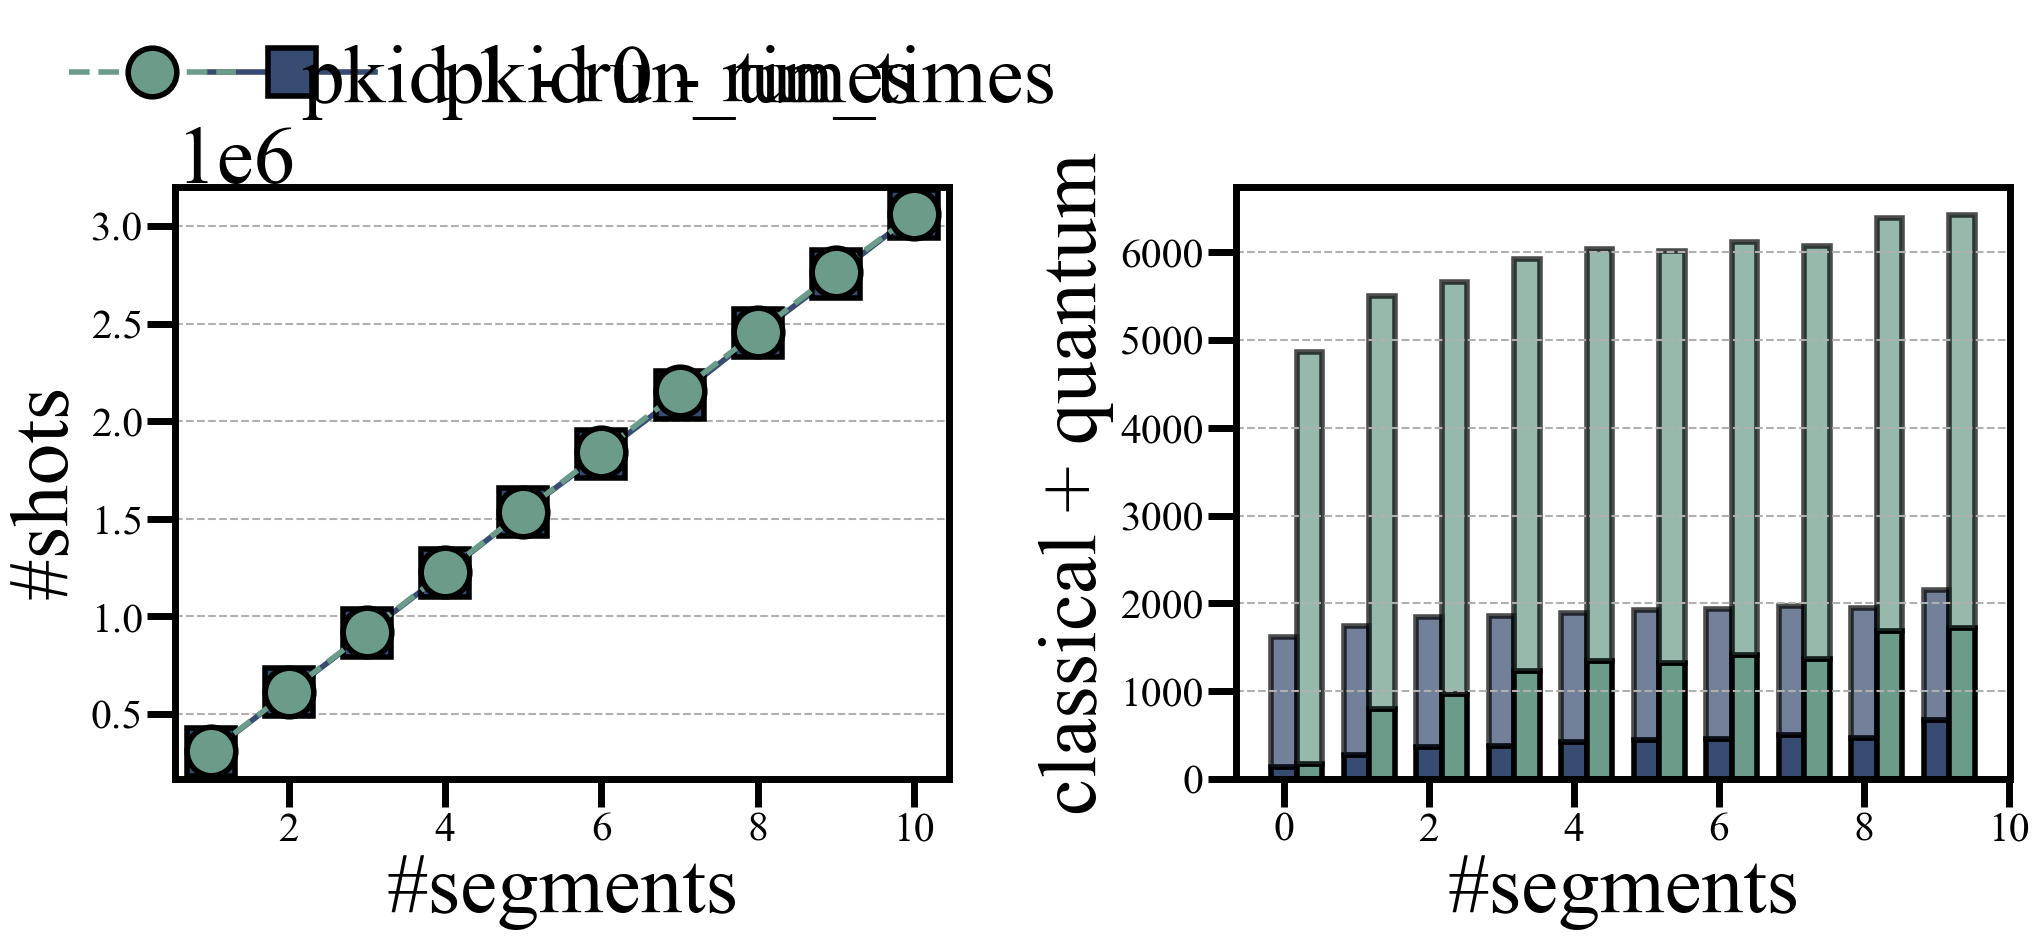

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Initialize the figure and axis settings
scale = 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22*scale, 12*scale))  # Create two subplots

mpl.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'Times New Roman',
    'font.size': 60,
    'axes.unicode_minus': False,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold',
    'axes.linewidth': 5,
    'xtick.major.size': 20,
    'xtick.major.width': 5,
    'xtick.minor.size': 10,
    'xtick.minor.width': 3,
    'ytick.major.size': 20,
    'ytick.major.width': 5,
    'ytick.minor.size': 10,
    'ytick.minor.width': 3,
    "lines.markersize" : 35,
    "lines.markeredgewidth" : 4,
    "markers.fillstyle" : 'full',
    'lines.markerfacecolor': '#f8d941',
    'lines.markeredgecolor': 'black',
})

# Colors and line styles
colors_ = ['#384B70', '#6A9C89']  # For runtime
colors_quantum = ['#B8001F', '#FF7F00']  # For quantum
line_styles = ['-', '--']

# Plot runtime on ax1
for idx, pkid_value in enumerate([0, 1]):  # pkid 0 and pkid 1 for two different lines
    data = grouped_df[grouped_df['pkid'] == pkid_value]
    x = data['num_segments']
    
    marker_style = 's' if pkid_value == 0 else 'o'  # pkid 0 uses square, pkid 1 uses circle
    
    ax1.plot(x, data['run_times'], 
             color=colors_[idx], 
             linestyle=line_styles[idx], 
             label=f'pkid {pkid_value} - run_times', 
             linewidth=4, 
             marker=marker_style,
             markerfacecolor=colors_[idx],  # Set marker color for runtime
             markeredgecolor='black')  # Edge color for marker

# Add grid, labels, and legend to runtime plot
ax1.grid(True, linestyle='--', linewidth=1.5, axis='y')
ax1.set_xlabel('#segments', fontsize=60)
ax1.set_ylabel('#shots ', fontsize=60)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.legend(loc='upper left', ncol=2, frameon=False, bbox_to_anchor=(0, 1.1, 1, 0.2), mode="expand", borderaxespad=0)

# Plot quantum and classical on ax2 as stacked bar chart
bar_width = 0.35
hatchs = ['//', '\\\\']  # For some texture effect if needed

for idx, pkid_value in enumerate([0, 1]):
    data = grouped_df[grouped_df['pkid'] == pkid_value]
    x = np.arange(len(data['num_segments']))  # X positions for each bar
    
    y_classical = data['classcial'].to_list()
    y_quantum = data['quantum'].to_list()

    # Plot 'classical' as the base of the stacked bar chart (opaque)
    ax2.bar(x + idx * bar_width, y_classical, width=bar_width, color=colors_[idx], label=f'pkid {pkid_value} classical', edgecolor="black", linewidth=4)

    # Plot 'quantum' on top of 'classical' (with transparency)
    ax2.bar(x + idx * bar_width, y_quantum, width=bar_width, bottom=y_classical, color=colors_[idx], alpha=0.7, label=f'pkid {pkid_value} quantum', edgecolor="black", linewidth=4)

# Add grid, labels, and legend to quantum and classical plot
ax2.grid(True, linestyle='--', linewidth=1.5, axis='y')
ax2.set_xlabel('#segments', fontsize=60)
ax2.set_ylabel('classical + quantum', fontsize=60)
ax2.tick_params(axis='x', labelsize=30)
ax2.tick_params(axis='y', labelsize=30)

# Customizing the legend
# ax2.legend(loc='upper left', ncol=2, frameon=False, bbox_to_anchor=(0, 1.1, 1, 0.2), mode="expand", borderaxespad=0)

# Save the figure
plt.tight_layout()
plt.savefig('runtime_quantum_separate_plots_with_stacked_bar_chart.svg', bbox_inches='tight')

# Show the figure
plt.show()


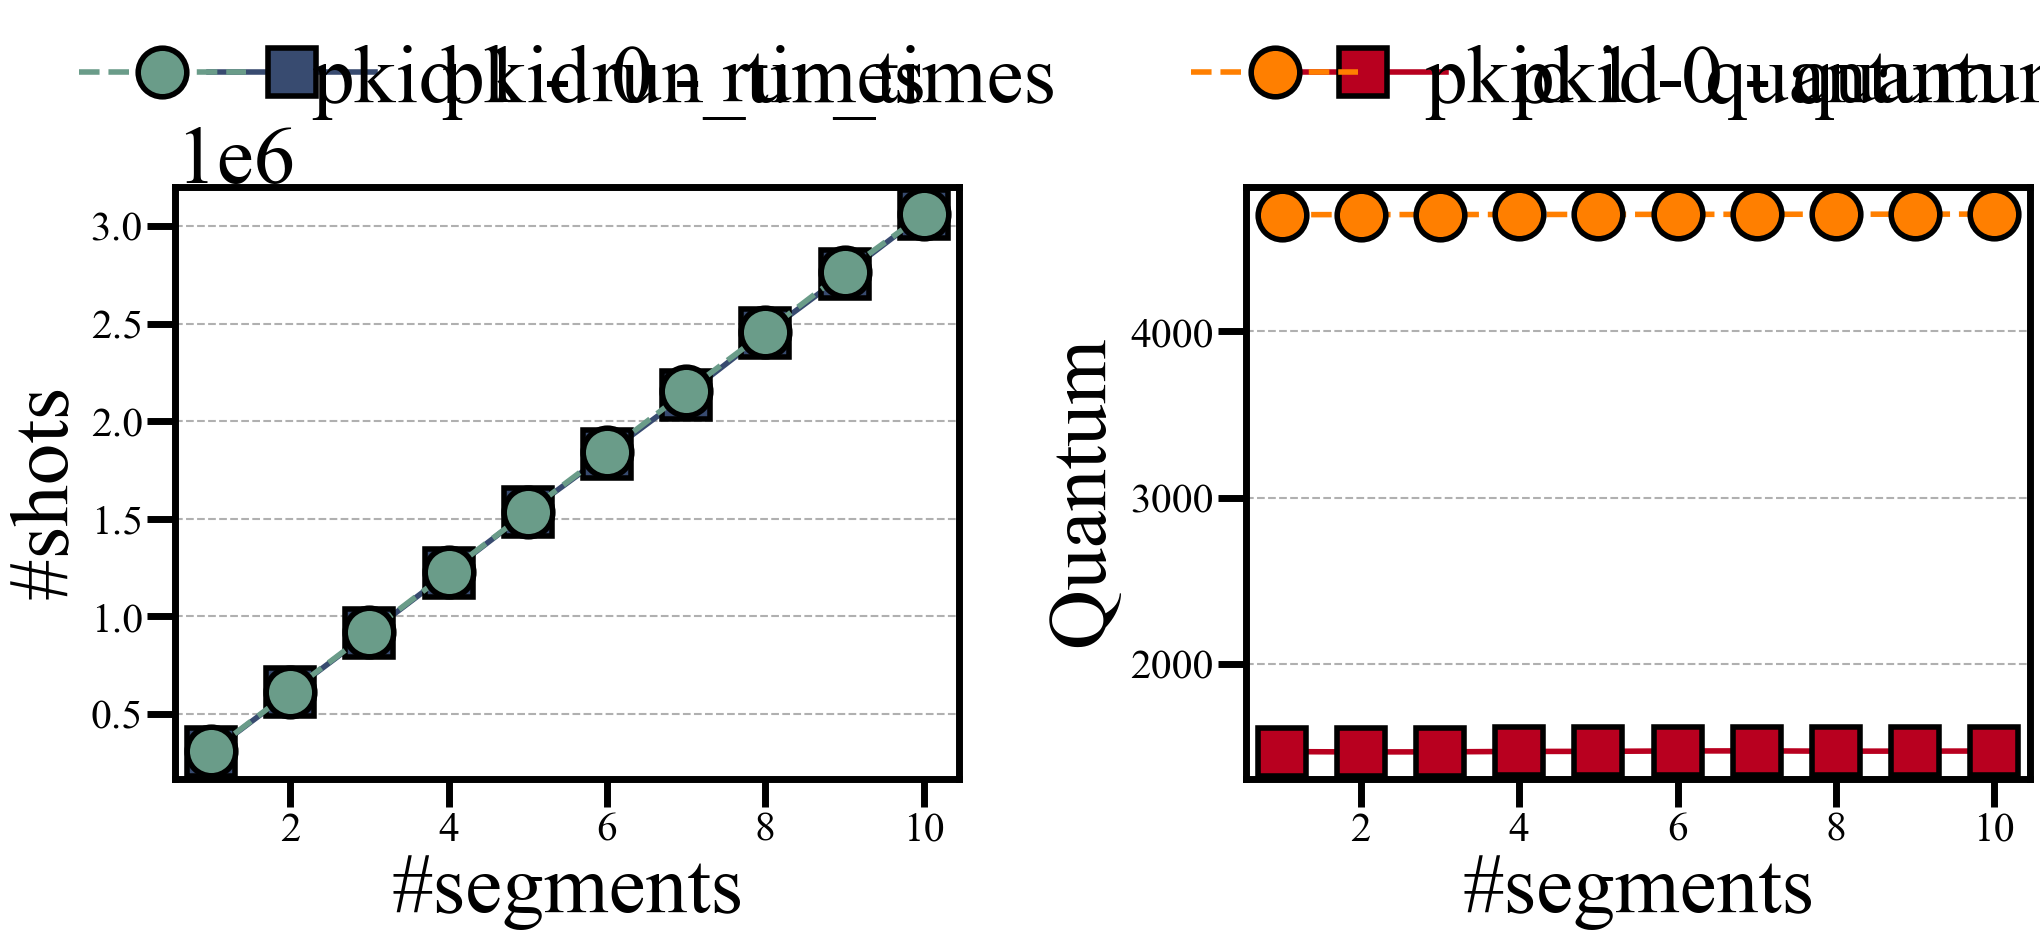

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Initialize the figure and axis settings
scale = 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22*scale, 12*scale))  # 创建两个子图

mpl.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'Times New Roman',
    'font.size': 60,
    'axes.unicode_minus': False,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold',
    'axes.linewidth': 5,
    'xtick.major.size': 20,
    'xtick.major.width': 5,
    'xtick.minor.size': 10,
    'xtick.minor.width': 3,
    'ytick.major.size': 20,
    'ytick.major.width': 5,
    'ytick.minor.size': 10,
    'ytick.minor.width': 3,
    "lines.markersize": 35,
    "lines.markeredgewidth": 4,
    "markers.fillstyle": 'full',
    'lines.markerfacecolor': '#f8d941',
    'lines.markeredgecolor': 'black',
})

# Colors and line styles
colors_ = ['#384B70', '#6A9C89']  # For runtime
colors_quantum = ['#B8001F', '#FF7F00']  # For quantum
line_styles = ['-', '--']

# Plot runtime on ax1
for idx, pkid_value in enumerate([0, 1]):  # pkid 0 and pkid 1 for two different lines
    data = grouped_df[grouped_df['pkid'] == pkid_value]
    x = data['num_segments']
    
    marker_style = 's' if pkid_value == 0 else 'o'  # pkid 0 uses square, pkid 1 uses circle
    
    ax1.plot(x, data['run_times'], 
             color=colors_[idx], 
             linestyle=line_styles[idx], 
             label=f'pkid {pkid_value} - run_times', 
             linewidth=4, 
             marker=marker_style,
             markerfacecolor=colors_[idx],  # Set marker color for runtime
             markeredgecolor='black')  # Edge color for marker

# Add grid, labels, and legend to runtime plot
ax1.grid(True, linestyle='--', linewidth=1.5, axis='y')
ax1.set_xlabel('#segments', fontsize=60)
ax1.set_ylabel('#shots ', fontsize=60)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.legend(loc='upper left', ncol=2, frameon=False, bbox_to_anchor=(0, 1.1, 1, 0.2), mode="expand", borderaxespad=0)

# Plot quantum on ax2
for idx, pkid_value in enumerate([0, 1]):
    data = grouped_df[grouped_df['pkid'] == pkid_value]
    x = data['num_segments']
    
    marker_style = 's' if pkid_value == 0 else 'o'  # pkid 0 uses square, pkid 1 uses circle
    
    ax2.plot(x, data['quantum'], 
             color=colors_quantum[idx], 
             linestyle=line_styles[idx], 
             label=f'pkid {pkid_value} - quantum', 
             linewidth=4, 
             marker=marker_style,
             markerfacecolor=colors_quantum[idx],  # Set marker color for quantum
             markeredgecolor='black')  # Edge color for marker

# Add grid, labels, and legend to quantum plot
ax2.grid(True, linestyle='--', linewidth=1.5, axis='y')
ax2.set_xlabel('#segments', fontsize=60)
ax2.set_ylabel('Quantum ', fontsize=60)
ax2.tick_params(axis='x', labelsize=30)
ax2.tick_params(axis='y', labelsize=30)
ax2.legend(loc='upper left', ncol=2, frameon=False, bbox_to_anchor=(0, 1.1, 1, 0.2), mode="expand", borderaxespad=0)
# ax2.set_ylim([1400, 1500])
# Save the figure
plt.tight_layout()
plt.savefig('runtime_quantum_separate_plots_marked_by_pkid.svg', bbox_inches='tight')

# Show the figure
plt.show()
